## Problem 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
ret_dat = pd.read_csv("DailyReturn.csv").drop("Unnamed: 0",axis=1)

# Lambda values for exponentially weighted covariance matrix
lambdas = [0.6, 0.7, 0.8, 0.9, 0.97, 0.99]

# Set Seaborn style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(lambdas))

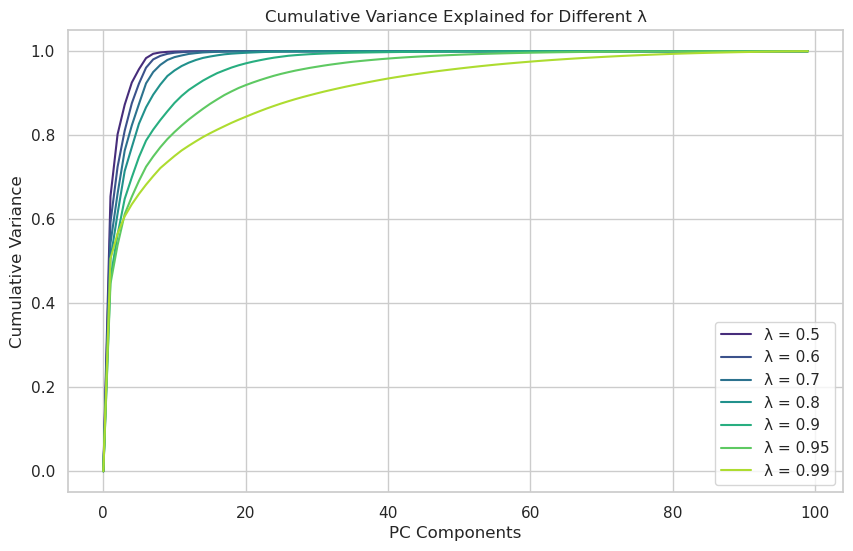

In [2]:
length, num_assets = ret_dat.shape
# Define the function to calculate the exponentially weighted covariance matrix
def compute_ew_cov_matrix(ret_dat, lambda_value):
    length, num_assets = ret_dat.shape
    weights = (1 - lambda_value) * (lambda_value ** np.arange(length)[::-1])
    weights /= weights.sum()
    centered_returns = ret_dat - ret_dat.mean()
    ew_cov_matrix = centered_returns.T @ np.diag(weights) @ centered_returns
    return ew_cov_matrix


# Define the PCA function to calculate cumulative variance explained by eigenvalues
def perform_pca(cov, num_components):
    eigenvalues = np.linalg.eigvalsh(cov)
    eigenvalues = np.sort(eigenvalues)[::-1]
    cum_var_explained = np.sum(eigenvalues[:num_components]) / np.sum(eigenvalues)
    return cum_var_explained


# Select a more comprehensive set of lambda values
lambdas = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# Use a visually appealing color palette
palette = sns.color_palette("viridis", len(lambdas))

# Generate the Seaborn plot with the updated color palette and lambda values
plt.figure(figsize=(10, 6))
for i, lambda_val in enumerate(lambdas):
    cov_matrix = compute_ew_cov_matrix(ret_dat, lambda_val)
    cum_variances = [perform_pca(cov_matrix, i) for i in range(num_assets)]
    sns.lineplot(x=range(len(cum_variances)), y=cum_variances, label=f"λ = {lambda_val}", color=palette[i])

plt.xlabel("PC Components")
plt.ylabel("Cumulative Variance")
plt.title("Cumulative Variance Explained for Different λ")
plt.legend()
plt.show()

## Problem 2

In [3]:

def chol_psd(psd_mat):
    n = psd_mat.shape[0]
    # Initialize the root matrix with zeros
    root = np.zeros((n, n))
    
    # Loop over each element in the matrix
    for i in range(n):
        for k in range(i+1):
            s = sum(root[i, j] * root[k, j] for j in range(k))
            
            if i == k:  # Diagonal elements
                root[i, k] = np.sqrt(max(psd_mat[i, i] - s, 0))
            else:  # Off-diagonal elements
                if root[k, k] > 1e-8:
                    root[i, k] = (1.0 / root[k, k]) * (psd_mat[i, k] - s)
                    
    return root

In [4]:

def near_psd(mat, epsilon=0.0):
    n = mat.shape[0]
    result = mat.copy()

    # Check if the input is a covariance matrix, and if so, convert to a correlation matrix
    if not np.allclose(np.diag(result), 1.0):
        scale = np.diag(1.0 / np.sqrt(np.diag(result)))
        result = scale @ result @ scale

    # Perform eigenvalue decomposition and adjust the eigenvalues
    eigenvalues, eigenvectors = np.linalg.eigh(result)
    adjusted_eigenvalues = np.maximum(eigenvalues, epsilon)

    # Reconstruct the positive semi-definite matrix
    result = eigenvectors @ np.diag(np.sqrt(adjusted_eigenvalues)) @ eigenvectors.T

    # If the input was a covariance matrix, scale back to the original scale
    if 'scale' in locals():
        result = np.linalg.inv(scale) @ result @ np.linalg.inv(scale)
    
    return result

In [5]:

def higham_psd(mat, max_iterations=1000, tolerance=1e-8):
    Y = mat.copy()
    delta_s = np.zeros_like(mat)

    if not np.allclose(np.diag(Y), 1.0):
        inv_sd = np.diag(1.0 / np.sqrt(np.diag(Y)))
        Y = inv_sd @ Y @ inv_sd

    Y_prev = Y.copy()
    
    for i in range(max_iterations):
        R = Y - delta_s
        eigenvalues, eigenvectors = np.linalg.eigh(R)
        eigenvalues = np.maximum(eigenvalues, 0)
        X = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
        delta_s = X - R
        Y = X.copy()
        np.fill_diagonal(Y, 1)

        # Check for convergence using the Frobenius norm of the difference between consecutive Y matrices
        if np.linalg.norm(Y - Y_prev, 'fro') < tolerance:
            break

        Y_prev = Y.copy()

    if 'inv_sd' in locals():
        Y = np.linalg.inv(inv_sd) @ Y @ np.linalg.inv(inv_sd)

    return Y


In [6]:
#Generate a non-psd correclation matrix that is 500x500
n = 500
sigma = np.full((n,n),0.9)
for i in range(n):
    sigma[i,i]=1.0
sigma[0,1] = 0.7357
sigma[1,0] = 0.7357

In [7]:
#Fix and Confirm matrix is PSD or not
def check_psd(mtx):
    eigenvalues = np.linalg.eigh(mtx)[0]
    return np.all(eigenvalues >= -1e-8)

print("Matrix generated is PSD:", check_psd(sigma))
print("Matrix fixed by near_psd is PSD:", check_psd(near_psd(sigma)))
print("Matrix fixed by Highan is PSD:", check_psd(higham_psd(sigma)))

Matrix generated is PSD: False
Matrix fixed by near_psd is PSD: True
Matrix fixed by Highan is PSD: True


In [9]:
import time
# Measure the runtime of near_psd and higham_nearest_psd and compute the Frobenius Norm of the difference
start_time_near_psd = time.time()
result_near_psd = near_psd(sigma)
runtime_near_psd = time.time() - start_time_near_psd

start_time_higham = time.time()
result_higham = higham_psd(sigma)
runtime_higham = time.time() - start_time_higham

# Compute the Frobenius Norm of the difference between the resulting matrices and the original matrix
frobenius_norm_near_psd = np.linalg.norm(result_near_psd - sigma, 'fro')
frobenius_norm_higham = np.linalg.norm(result_higham - sigma, 'fro')

print(f"Runtime of near_psd: {runtime_near_psd} seconds\n")
print(f"Runtime of higham_psd: {runtime_higham} seconds\n")
print(f"Forbenium Norm of the difference between the near_psd matrix and the original matrix: {frobenius_norm_near_psd}\n")
print(f"Forbenium Norm of the difference between the higham_psd matrix and the original matrix: {frobenius_norm_higham}\n")

Runtime of near_psd: 0.19433045387268066 seconds

Runtime of higham_psd: 4.945196628570557 seconds

Forbenium Norm of the difference between the near_psd matrix and the original matrix: 428.9109648458238

Forbenium Norm of the difference between the higham_psd matrix and the original matrix: 0.08964798746837777



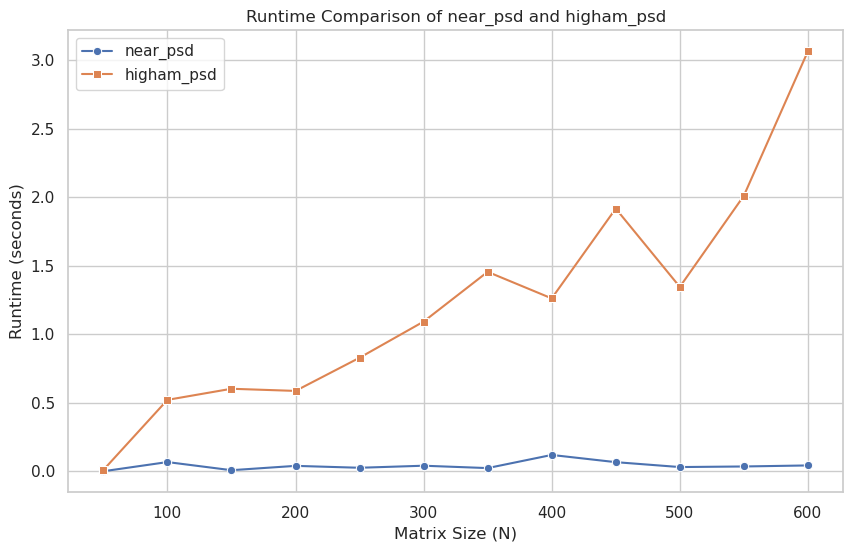

In [14]:
matrix_sizes = np.arange(50,601,50)
# Initialize lists to store runtimes
runtimes_near_psd = []
runtimes_higham_psd = []

# Loop over matrix sizes and measure the runtime for each function
for n in matrix_sizes:
    # Generate a non-PSD correlation matrix of size n x n
    non_psd_matrix = np.full((n, n), 0.9)
    np.fill_diagonal(non_psd_matrix, 1.0)
    non_psd_matrix[0, 1] = non_psd_matrix[1, 0] = 0.7357
    
    # Measure the runtime of near_psd function
    start_time_near_psd = time.time()
    near_psd_result = near_psd(non_psd_matrix)
    runtimes_near_psd.append(time.time() - start_time_near_psd)
    
    # Measure the runtime of optimized_higham_psd function
    start_time_higham_psd = time.time()
    higham_psd_result = higham_psd(non_psd_matrix)
    runtimes_higham_psd.append(time.time() - start_time_higham_psd)

# Plot the runtimes against matrix sizes using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=matrix_sizes, y=runtimes_near_psd, marker='o', label='near_psd')
sns.lineplot(x=matrix_sizes, y=runtimes_higham_psd, marker='s', label='higham_psd')
plt.xlabel('Matrix Size (N)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of near_psd and higham_psd')
plt.legend()
plt.show()

## Problem 3